In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
solvation_energy_df = pd.read_csv('SAMPL.csv')
print(solvation_energy_df.shape)
solvation_energy_df[:5]

(642, 4)


,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


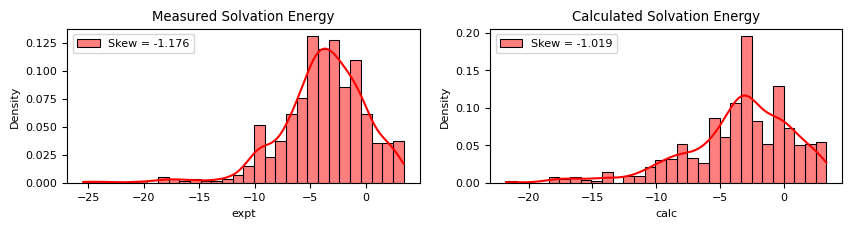

In [3]:
# the distribution of solvation energy  
plt.figure(figsize=(10, 2))
plt.rc('font', size=8)  

plt.subplot(1, 2, 1)
skew=solvation_energy_df['expt'].skew()
sns.histplot(solvation_energy_df['expt'], kde=True, stat="density", label='Skew = %.3f' %(skew), 
             bins=30, color='r')
plt.legend(loc='best')
plt.title('Measured Solvation Energy')

plt.subplot(1, 2, 2)
skew=solvation_energy_df['calc'].skew()
sns.histplot(solvation_energy_df['calc'], kde=True, stat="density", label='Skew = %.3f' %(skew), 
             bins=30, color='r')
plt.legend(loc='best')
plt.title('Calculated Solvation Energy')
plt.show()

# - value exothermic reaction while solvation 
# + value endothermic reaction while solvation

In [4]:
# fingerprint transformer with max atomic bond
from scikit_mol.fingerprints import RDKitFingerprintTransformer
transformer = RDKitFingerprintTransformer()
transformer

RDKitFingerprintTransformer()

In [5]:
parameters = transformer.get_params()
parameters

{'branchedPaths': True,
 'countBounds': None,
 'countSimulation': False,
 'fpSize': 2048,
 'maxPath': 7,
 'minPath': 1,
 'numBitsPerFeature': 2,
 'parallel': False,
 'safe_inference_mode': False,
 'useBondOrder': True,
 'useCounts': False,
 'useHs': True}

In [6]:
# max atomic bond 5
parameters["maxPath"] = 5
transformer.set_params(**parameters)
transformer

RDKitFingerprintTransformer(maxPath=5)

In [7]:
from rdkit import Chem
smiles_strings = ["CC[C@@H](C)CO", "CCCCCCC", "CCCCCC(=O)O"]
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_strings]
mols

# tert-butyl alcohol, hexanoic acid, heptane


In [8]:
solvation_energy_df.loc[(solvation_energy_df.smiles == "CC[C@@H](C)CO")| 
                        (solvation_energy_df.smiles == "CCCCCC(=O)O")| 
                        (solvation_energy_df.smiles == "CCCCCCC")]

,iupac,smiles,expt,calc
51,2-methylbutan-1-ol,CC[C@@H](C)CO,-4.42,-2.995
88,heptane,CCCCCCC,2.67,2.925
157,hexanoic acid,CCCCCC(=O)O,-6.21,-7.878


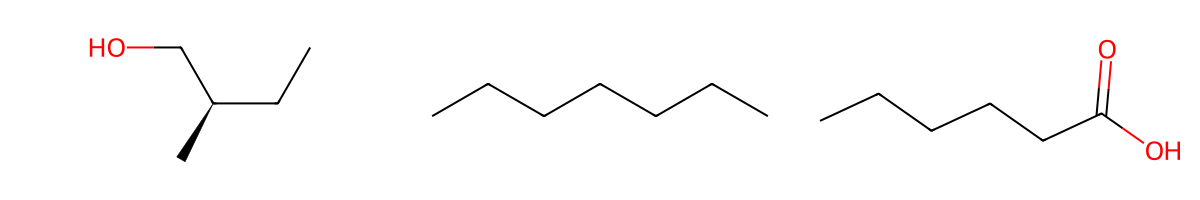

In [9]:
from rdkit.Chem import Draw
from IPython.display import Image, display

mols_img = Draw.MolsToGridImage(mols, molsPerRow=len(mols), subImgSize=(400, 200))
display(mols_img)

In [10]:
fps = transformer.transform(mols)
print(f"{fps.__class__=}")
print(f"{fps.shape=}")

fps.__class__=<class 'numpy.ndarray'>
fps.shape=(3, 2048)


In [11]:
# import library
from rdkit.Chem import PandasTools
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scikit_mol.descriptors import MolecularDescriptorTransformer
from scikit_mol.conversions import SmilesToMolTransformer


In [12]:
# generate and loading mols

PandasTools.AddMoleculeColumnToFrame(solvation_energy_df, smilesCol="smiles")
print(f"{solvation_energy_df.ROMol.isna().sum()} out of {len(solvation_energy_df)} SMILES failed in conversion")
print(solvation_energy_df.shape)
solvation_energy_df.head()

0 out of 642 SMILES failed in conversion
(642, 5)


,iupac,smiles,expt,calc,ROMol
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,<rdkit.Chem.rdchem.Mol object at 0x789389b099a0>
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,<rdkit.Chem.rdchem.Mol object at 0x789389b09af0>
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,<rdkit.Chem.rdchem.Mol object at 0x789389b09a10>
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,<rdkit.Chem.rdchem.Mol object at 0x789389b09b60>
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917,<rdkit.Chem.rdchem.Mol object at 0x789389b09bd0>


In [13]:
# train and test dataset with experimental solubility
X_train, X_test, y_train, y_test = train_test_split(
    solvation_energy_df.ROMol, solvation_energy_df.expt, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((481,), (161,), (481,), (161,))

In [14]:
X_train

211    <rdkit.Chem.rdchem.Mol object at 0x789389b5f6f0>
43     <rdkit.Chem.rdchem.Mol object at 0x789389b0ace0>
42     <rdkit.Chem.rdchem.Mol object at 0x789389b0ac70>
73     <rdkit.Chem.rdchem.Mol object at 0x789389b0ba00>
327    <rdkit.Chem.rdchem.Mol object at 0x789389b62a40>
                             ...                       
71     <rdkit.Chem.rdchem.Mol object at 0x789389b0b920>
106    <rdkit.Chem.rdchem.Mol object at 0x789389b5c900>
270    <rdkit.Chem.rdchem.Mol object at 0x789389b61150>
435    <rdkit.Chem.rdchem.Mol object at 0x789389b65a10>
102    <rdkit.Chem.rdchem.Mol object at 0x789389b5c740>
Name: ROMol, Length: 481, dtype: object

In [18]:
# molecular descriptors from smiles
descriptor_calculator = MolecularDescriptorTransformer(desc_list=[
    "MolWt",                   # Molecular Weight
    "BalabanJ",                # Balaban's J index
    "NumRotatableBonds",       # Number of rotatable bonds
    "NumHDonors",              # Number of hydrogen bond donors
    "NumHAcceptors",           # Number of hydrogen bond acceptors
    "TPSA",                    # Topological Polar Surface Area
    "MolLogP",                 # LogP (octanol-water partition coefficient)
    "LabuteASA",               # Labute's Approximate Surface Area
    "PEOE_VSA1",               # PEOE-based VSA descriptors (example subset)
    "PEOE_VSA2",               # PEOE-based VSA descriptors
    "NumAromaticRings",        # Number of aromatic rings
                  # Number of halogen atoms
        # Inertial Shape Factor (requires 3D)
])

descriptor_calculator

MolecularDescriptorTransformer(desc_list=['MolWt', 'BalabanJ',
                                          'NumRotatableBonds', 'NumHDonors',
                                          'NumHAcceptors', 'TPSA', 'MolLogP',
                                          'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA2',
                                          'NumAromaticRings'])

In [19]:
desc_pipeline = make_pipeline(descriptor_calculator, PolynomialFeatures(degree=2))
desc_pipeline

Pipeline(steps=[('moleculardescriptortransformer',
                 MolecularDescriptorTransformer(desc_list=['MolWt', 'BalabanJ',
                                                           'NumRotatableBonds',
                                                           'NumHDonors',
                                                           'NumHAcceptors',
                                                           'TPSA', 'MolLogP',
                                                           'LabuteASA',
                                                           'PEOE_VSA1',
                                                           'PEOE_VSA2',
                                                           'NumAromaticRings'])),
                ('polynomialfeatures', PolynomialFeatures())])

In [20]:
fingerprinter = RDKitFingerprintTransformer(maxPath=5)
fingerprinter

RDKitFingerprintTransformer(maxPath=5)

In [21]:
features_pipeline = make_union(desc_pipeline, fingerprinter)
features_pipeline

FeatureUnion(transformer_list=[('pipeline',
                                Pipeline(steps=[('moleculardescriptortransformer',
                                                 MolecularDescriptorTransformer(desc_list=['MolWt',
                                                                                           'BalabanJ',
                                                                                           'NumRotatableBonds',
                                                                                           'NumHDonors',
                                                                                           'NumHAcceptors',
                                                                                           'TPSA',
                                                                                           'MolLogP',
                                                                                           'LabuteASA',
                                                                                           'PEOE_VSA1',
                                                                                           'PEOE_VSA2',
                                                                                           'NumAromaticRings'])),
                                                ('polynomialfeatures',
                                                 PolynomialFeatures())])),
                               ('rdkitfingerprinttransformer',
                                RDKitFingerprintTransformer(maxPath=5))])

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [23]:
# Define regressors
regressors = {
    "RandomForest": RandomForestRegressor(),
    "Ridge": Ridge(),
    "DecisionTree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(),
}


In [24]:
# Loop through each regressor
for name, estimator in regressors.items():
    model = make_pipeline(features_pipeline, estimator)  # Create pipeline
    model.fit(X_train, y_train)  # Fit model to training data

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Print results
    print(f"Model: {name}")
    print(f"Train score: {model.score(X_train, y_train):.4f}")
    print(f"Test score: {model.score(X_test, y_test):.4f}")
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print("-" * 30)

Model: RandomForest
Train score: 0.9838
Test score: 0.9373
Train RMSE: 0.4873, Test RMSE: 0.9624
Train MAE: 0.2952, Test MAE: 0.6891
------------------------------
Model: Ridge
Train score: 0.5852
Test score: 0.4248
Train RMSE: 2.4676, Test RMSE: 2.9151
Train MAE: 1.7688, Test MAE: 1.8988
------------------------------
Model: DecisionTree
Train score: 1.0000
Test score: 0.8762
Train RMSE: 0.0165, Test RMSE: 1.3524
Train MAE: 0.0015, Test MAE: 0.9124
------------------------------
Model: XGBoost
Train score: 0.9999
Test score: 0.9303
Train RMSE: 0.0322, Test RMSE: 1.0149
Train MAE: 0.0210, Test MAE: 0.6495
------------------------------


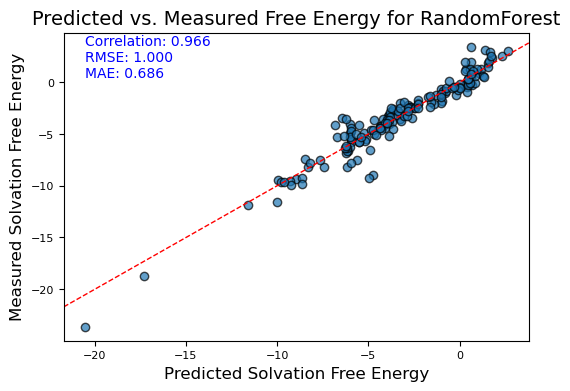

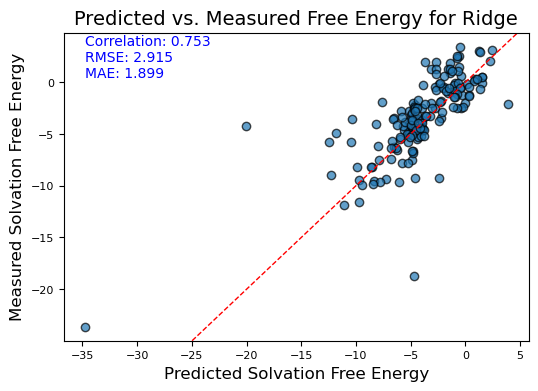

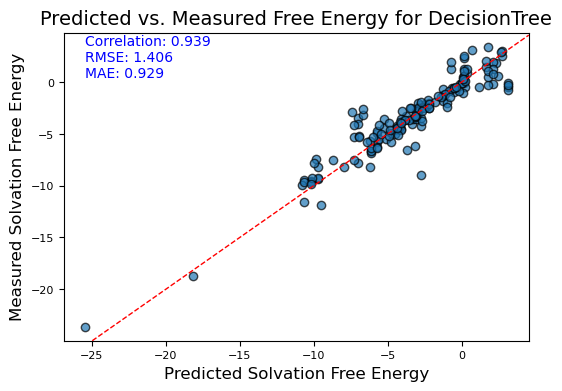

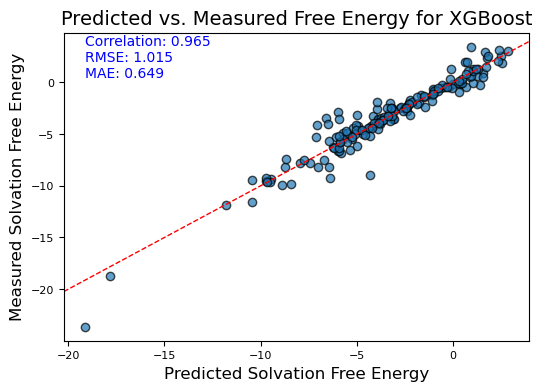

In [25]:
# Loop through each regressor
for name, estimator in regressors.items():
    model = make_pipeline(features_pipeline, estimator)  # Create pipeline
    model.fit(X_train, y_train)  # Fit model to training data

    # Predictions
    y_test_pred = model.predict(X_test)

    # Metrics
    correlation = np.corrcoef(y_test_pred, y_test)[0, 1]
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_pred, y_test, alpha=0.7, edgecolors='k')
    plt.xlabel('Predicted Solvation Free Energy', fontsize=12)
    plt.ylabel('Measured Solvation Free Energy', fontsize=12)
    plt.title(f'Predicted vs. Measured Free Energy for {name}', fontsize=14)
    plt.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1)
    plt.text(min(y_test_pred), max(y_test)-3, f"Correlation: {correlation:.3f}\nRMSE: {test_rmse:.3f}\nMAE: {test_mae:.3f}", 
             fontsize=10, color='blue')
    plt.show()